<a href="https://colab.research.google.com/github/jindojojin/SlitherlinkSolver/blob/main/SATSOLVER_TRANQUANGLINH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [2]:
! pip install python-sat
! pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Solver

In [3]:
from pysat.solvers import Solver
def sat_solve(cnf):
  s = Solver(name = "minisat22", use_timer=True)
  for cl in cnf:
    if (len(cl) > 0):
      s.add_clause(cl)
  if(s.solve()):
    print(s.time())
    # print(s.get_model())
    return s.get_model()
  else:
    print("UNSAT")
    return []

# Encoding methods

## utils

In [6]:
# Sinh tổ hợp chập k của N
memo = {}
def C(k,N):
  if(f"{k}-{N}" in memo):
    return memo[f"{k}-{N}"]
  result =[]
  used=[False]*N
  temp=[0]*k
  def backtrack(i):
    if( i == k ):
      result.append(temp.copy())
      return
    for j in range(N):
      if(not used[j]):
        if(i>0 and j < temp[i-1]): continue
        temp[i]=j
        used[j]=True
        backtrack(i+1)
        used[j] = False
  backtrack(0);
  memo[f"{k}-{N}"] = result.copy()
  return result.copy()

## Binomal encoding

In [12]:
# Binomal

def at_least_binormal(vars, k , condition=True):
  encoding_data = []
  for com in C(len(vars)-k+1, len(vars)):
    clause = []
    for idx in com:
      clause.append(vars[idx] if condition else -vars[idx])
    encoding_data.append(clause.copy())
  return encoding_data.copy()

def at_most_binomal(vars,k,condition=True):
  return at_least_binormal(vars,len(vars)-k,not condition).copy()

def exactly_binomal(total_var,vars,k,condition=True):
  return (
    at_most_binomal(vars,k,condition) + at_least_binormal(vars,k,condition),
    0
  )


## Commander encoding

In [13]:
# Commander
import math
def at_most_one_commander(var_count, vars, groupSize=2, condition = True):
  encoding_data=[]
  addition_vars=[]
  for group in range(math.ceil(len(vars)/groupSize)):
    var_count+=1
    addition_vars.append(var_count)
    group_vars = vars[group*groupSize:(group+1)*groupSize]
    encoding_data += at_most_binominal(group_vars,1,condition)
    if(condition):
      encoding_data += [[-var_count] + group_vars]
      for v in group_vars:
        encoding_data += [[var_count, -v]]
    else:
      encoding_data += [[-var_count] + list(map(lambda x: -x, group_vars))]
      for v in group_vars:
        encoding_data += [[-var_count, v]]
  encoding_data += exactly_binominal(var_count,addition_vars,1,condition)[0]
  return encoding_data

def exactly_commander(total_var, vars, groupSize, condition=True):
  if (groupSize == 1):
    groupSize = int(math.sqrt(len(vars)))
  return (at_most_one_commander(total_var, vars, groupSize, condition) + at_least_binominal(vars,1,condition),
      math.ceil(len(vars)/groupSize)
  )

exactly_commander(6,[1,2,3,4,5,6],3,True)

([[-1, -2],
  [-1, -3],
  [-2, -3],
  [-7, 1, 2, 3],
  [7, -1],
  [7, -2],
  [7, -3],
  [-4, -5],
  [-4, -6],
  [-5, -6],
  [-8, 4, 5, 6],
  [8, -4],
  [8, -5],
  [8, -6],
  [-7, -8],
  [7, 8],
  [1, 2, 3, 4, 5, 6]],
 2)

# Sudoku

In [14]:
import math
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

def draw_sudoku(data):
  N = len(data[0])
  figSize = 0.7*N
  cellSize=0.7/figSize
  fig, ax1 = plt.subplots(figsize=(figSize, figSize))
  ax1.axis('off')

  table = ax1.table(cellColours=[["1"],["1"]],loc='center',cellLoc='center')
  for row in range(N):
    for col in range(N):
      table.add_cell(row=row,col=col,width=cellSize,height=cellSize,text=f"{data[row][col]+1}",loc="center" )
  table.set_fontsize(12)

  plt.savefig("demo_table.png", dpi=200, bbox_inches='tight')

class Sudoku:
  def __init__(self, input, exact_encoder = exactly_binomal):
    self.N = len(input[0])
    self.VAR_COUNT = N*N*N
    self.cnf=[]
    self.input = input
    self.exact_encoder = exact_encoder 

  def get_index(self,i,j,k):
    return self.N*(self.N*i + j) + k + 1

  def get_loc(self,idx):
    idx = idx - 1
    k = idx % self.N
    idx = idx // self.N
    j = idx % self.N
    i = idx // self.N
    return (i,j,k)

  def get_sudoku_matrix(self,sat_solve_result):
    sudoku_matrix= [ [0]*self.N for i in range(self.N)]
    for var in sat_solve_result:
      if(var > 0 and var <= self.N**3):
        i,j,k = self.get_loc(var)
        sudoku_matrix[i][j] = k
    return sudoku_matrix

  def add_to_cnf(self,vars):
    rules,add_var_count = self.exact_encoder(self.VAR_COUNT,vars,1,True)
    self.cnf += rules
    self.VAR_COUNT += add_var_count

  def solve(self):
    # init rules
    for row in range(self.N):
      for col in range(self.N):
        if(self.input[row][col] >= 0):
          self.cnf += [self.get_index(row,col,input[row][col])]

    # Column rules
    for col in range(self.N):
      for num in range(self.N):
        vars = []
        for row in range(self.N):
          # if(input[row][col] >=0): continue
          vars.append(self.get_index(row,col,num))
        self.add_to_cnf(vars)

    # Row rules
    for row in range(self.N):
      for num in range(self.N):
        vars =[]
        for col in range(self.N):
          # if(input[row][col] >=0): continue
          vars.append(self.get_index(row,col,num))
        self.add_to_cnf(vars)

    # Cell rules
    for row in range(self.N):
      for col in range(self.N):
        # if(input[row][col] >=0): continue
        vars =[]
        for num in range(self.N):
          vars.append(self.get_index(row,col,num))
        self.add_to_cnf(vars)

    # Block rules
    # check block rule available
    n = math.sqrt(self.N)
    if(int(n) == n):
      n = int(n)
      for block in range(self.N):
        for num in range(self.N):
          b_row = (block // n) * n
          b_col = (block % n) * n  
          vars =[]
          for row in range(b_row, b_row + n):
            for col in range(b_col, b_col + n):
              vars.append(self.get_index(row,col,num))
          self.add_to_cnf(vars)
    print(f"N = {self.N}")
    print(f"VAR_COUNT = {self.VAR_COUNT}")
    print("final CNF: ", self.cnf)

    result = sat_solve(self.cnf)
    return self.get_sudoku_matrix(result)

N = 25
VAR_COUNT = 15625
final CNF:  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.022891999999998802


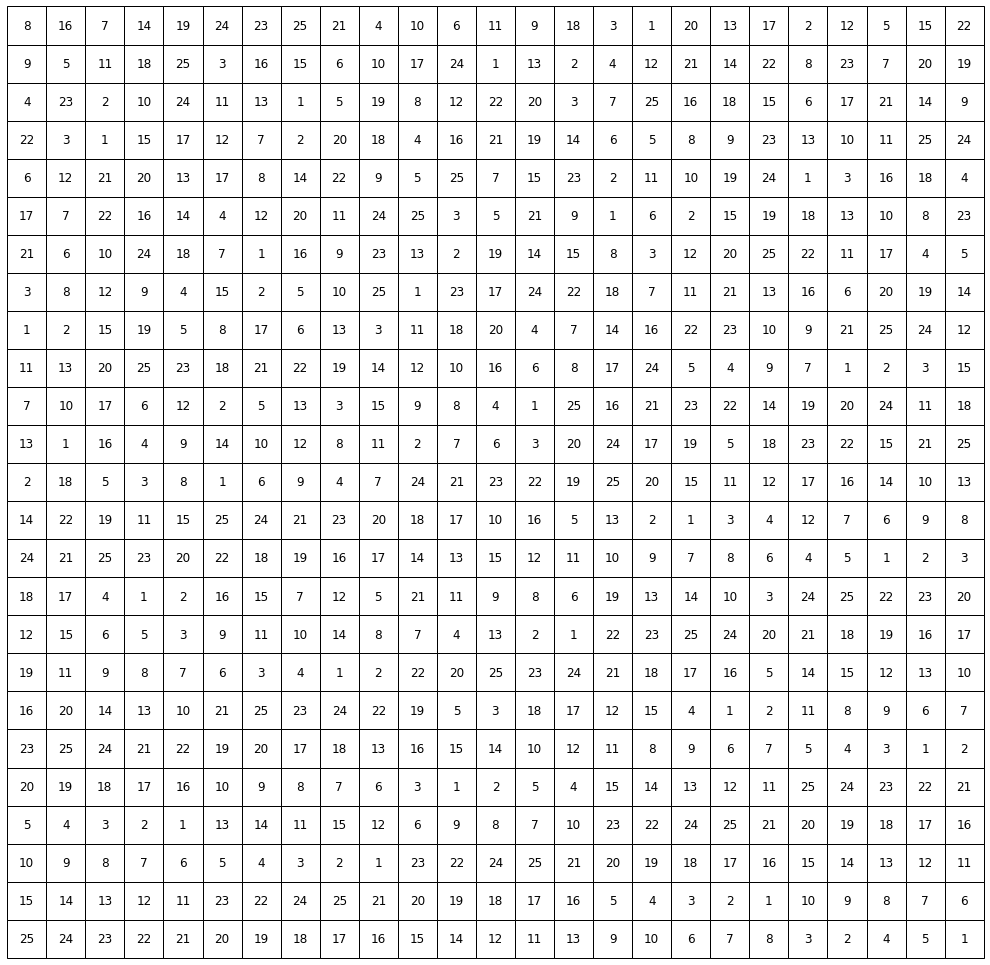

In [16]:
N = 25
sudoku1=[[-1]*N]*N
exe = Sudoku(sudoku1,exactly_binomal)
matrix = exe.solve()
# print(matrix)
draw_sudoku(matrix)


# NumberLink

In [ ]:
import random
class NumberLink:
  def __init__(self,input, exact_encoder = exactly_binominal):
    self.input = input
    self.ROW = len(input)
    self.COL = len(input[0])
    self.exact_encoder = exact_encoder
    self.Label_count = 0
    for row in range(self.ROW):
      for col in range(self.COL):
        if(input[row][col]>=0): self.Label_count+=1
    self.Label_count = int(self.Label_count/2)
    self.MAX_VALUE = self.VAR_COUNT = self.ROW * self.COL * self.Label_count
    self.cnf=[]
    self.colors=["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(self.Label_count)]
  
  def draw(self):
    if(len(self.result)):
      figSizeW = 0.7*self.COL
      figSizeH = 0.7*self.ROW
      cellSize=0.7/figSizeW
      fig, ax1 = plt.subplots(figsize=(figSizeW, figSizeH))
      ax1.axis('off')

      table = ax1.table(cellColours=[["1"],["1"]],loc='center',cellLoc='center')
      for row in range(self.ROW):
        for col in range(self.COL):
          label = self.result[row][col]
          table.add_cell(row=row,col=col,width=cellSize,height=cellSize,text=f"{ label+ 1}" if label >= 0 else "",loc="center",facecolor= self.colors[label] if label >= 0 else "w")
      table.set_fontsize(12)

      plt.savefig("numberlink.png", dpi=200, bbox_inches='tight')

  def get_index(self,i,j,k):
    return self.Label_count*(self.ROW*i + j) + k + 1

  def get_loc(self,idx):
    idx = idx - 1
    k = idx % self.Label_count
    idx = idx // self.Label_count
    j = idx % self.ROW
    i = idx // self.ROW
    return (i,j,k)

  def get_number_link_matrix(self,sat_solve_result):
    number_link_matrix= [ [-1]*self.COL for i in range(self.ROW)]
    for var in sat_solve_result:
      if(self.idx_in_matrix(var)):
        i,j,k = self.get_loc(var)
        number_link_matrix[i][j] = k
    return number_link_matrix

  def idx_in_matrix(self,idx):
    return idx > 0 and idx <= self.MAX_VALUE
  
  def list_neighbor_cell_index(self, row, col, num):
    dr=[1,-1,0,0]
    dc=[0,0,1,-1]
    nbr_cells=[]
    for i in range(4):
      idx = self.get_index(row + dr[i],col + dc[i],num)
      if(self.idx_in_matrix(idx)):
        nbr_cells.append(idx)
    return nbr_cells

  def add_4_block_rule(self,row,col,num):
    dr=[[ 0, 1, 1],[ 0,-1, 1],[ 0,-1,-1],[-1, 0,-1]]
    dc=[[-1, 0,-1],[ 1, 0, 1],[ 1, 0, 1],[ 0,-1,-1]]

    var1 = self.get_index(row,col,num) 
    for b_idx in range(4):
      var2 = self.get_index(row+dr[b_idx][0],col+dc[b_idx][0],num)
      var3 = self.get_index(row+dr[b_idx][1],col+dc[b_idx][1],num)
      var4 = self.get_index(row+dr[b_idx][2],col+dc[b_idx][2],num)
      if(self.idx_in_matrix(var2) and self.idx_in_matrix(var3) and self.idx_in_matrix(var4)):
        #(var1 ^ var2 ^ var3) -> -var4
        self.cnf += [[-var1,-var2,-var3,-var4]]
      
  def solve(self):
    # Cell rules
    for row in range(self.ROW):
      for col in range(self.COL):
        if(self.input[row][col] >= 0): # Nhãn được điền sẵn
          self.cnf += [[self.get_index(row,col,self.input[row][col])]] 

          # Chính xác 1 ô trong 4 ô xung quanh được điền nhãn giống nó
          vars = self.list_neighbor_cell_index(row,col,self.input[row][col])
          rules,add_var_count = self.exact_encoder(self.VAR_COUNT,vars,1,True)
          self.cnf += rules
          self.VAR_COUNT += add_var_count

        else: # Nhãn chưa được điền
          label_vars =[]
          for num in range(self.Label_count):
            label = self.get_index(row,col,num) # Nhãn giả định
            label_vars.append(label)

            nbr_label_vars = self.list_neighbor_cell_index(row,col,num) # Lấy danh sách biến các ô xung quanh nếu có nhãn giống nhãn giả định
            rules, add_var_count = self.exact_encoder(self.VAR_COUNT,nbr_label_vars,2,True) #Chính xác 2 ô xung quanh có nhãn giống nhãn giả định
            # Nếu nhãn giả định được chọn, chính xác 2 ô xung quanh nó được gán nhãn giống nó
            for rule in rules: # var -> (x1 V X2) ^ (x3 V x4)  <=> (-var V x1 V x2) ^ (-var V x3 V x4)
              self.cnf += [[-label] + rule]
            self.VAR_COUNT += add_var_count

            self.add_4_block_rule(row,col,num)

          self.cnf += self.exact_encoder(self.VAR_COUNT,label_vars,1,True)[0] # Chính xác 1 nhãn được chọn

    print(f"VAR_COUNT = {self.VAR_COUNT}")
    print(f"Label_count = {self.Label_count}")
    print("final CNF: ", self.cnf)

    result = sat_solve(self.cnf)
    self.result = self.get_number_link_matrix(result)
    return self.result




In [ ]:
m= [[ 0,-1,-1,-1, 1,-1,-1,-1,-1]]
m+=[[-1,-1, 3,-1,-1,-1,-1,-1,-1]]
m+=[[-1,-1,-1,-1,-1,-1,-1,-1,-1]]
m+=[[-1, 2,-1,-1,-1,-1,-1,-1,-1]]
m+=[[-1,-1,-1,-1, 2,-1,-1, 0,-1]]
m+=[[ 1,-1,-1,-1, 4,-1,-1,-1,-1]]
m+=[[-1,-1,-1,-1,-1,-1,-1,-1, 5]]
m+=[[-1, 3,-1,-1, 4,-1,-1,-1,-1]]
m+=[[-1,-1,-1,-1,-1,-1, 5,-1,-1]]
exe = NumberLink(m)
matrix = exe.solve()
print("Number link")
for row in matrix:
  print(row)
exe.draw()